# Read SUMMA output

In [15]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys, pickle, os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

In [16]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/'

dirProj = dirPre + 'SnowHydrology/proj/ModTsfc/'
dirPrint = dirProj + 'Graphics'
dirData = dirProj + 'data'
dirSumma = dirProj + 'summa/ModTsfc_summa/output/'

## Functions to quickly evaluate all model output

In [17]:
def evalSWE(dsDict, obs):
    # SWE
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for ex in dsDict:
        ax.plot(dsDict[ex].time, dsDict[ex].scalarSWE, label=ex)
    ax.set_ylabel('SWE (mm)')
    plt.legend(loc='best')
    
def evalSurfTemp(dsDict, obs):
    # Tsurf scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    for ex in dsDict:
        ax.plot(dsDict[ex].scalarSurfaceTemp - 273.15, obs.Tsrf, '.', label=ex)
    ax.plot([-30, 0], [-30, 0], 'k--')
    ax.set_xlabel('Model Ts')
    ax.set_ylabel('Obs Ts')
    ax.set_xlim(-30, 0)
    ax.set_ylim(-30, 0)
    plt.legend(loc='best')

def evalDiurnalTs(dsDict, obs):
    # Tsurf scatter plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    hours = np.arange(0, 24)
    for n, ex in enumerate(dsDict):
        ax.plot(hours, dsDict[ex].scalarSurfaceTemp.groupby('time.hour').mean(dim='time') - 273.15, label=ex)
    ax.plot(hours, obs.snowTs.groupby('time.hour').mean(dim='time'), 'k', linewidth=3, label='Obs.')
    ax.plot([0, 23], [0, 0], color='.5')
    ax.set_xlim(0, 23)
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('T ($^{\circ}$)')
    plt.legend(loc='best')
    

In [21]:
os.chdir(dirData)
SWA = xr.open_dataset('SWA.ModTsfc.nc')
SNQ = xr.open_dataset('SNQ.ModTsfc.nc')
CDP = xr.open_dataset('CDP.ModTsfc.nc')

# --------------------------------------------------------------------------------------------
# Select only the model forcing period
CDP = CDP.loc[dict(time = slice(datetime(2005, 10, 1), datetime(2006, 9, 1)))]
SWA = SWA.loc[dict(time = slice(datetime(2008, 10, 1), datetime(2009, 9, 1)))]

## Model output

### Define control lists etc

In [19]:
siteNames = ['SWA']
siteYears = {'SWA': 2008}
experiments = ['layers', 'thermalCond', 'stability', 'longwaveBias']

# Layer
expNames = {'layers': ['layerThin', 'layerThick', 'jrdn1991', 'CLM_2010']}
# Longwave bias
expNames['longwaveBias'] = ['lowLW', 'obsLW', 'highLW']
# Thermal conductivity
arrayNames = ['tyen1965', 'melr1977', 'jrdn1991', 'smnv2000']
arrayAppend = ['Mid', 'Low', 'High']
expNames['thermalCond'] = [name + append for name in arrayNames for append in arrayAppend]
# Stability
arrayAppend = ['Low', 'Mid', 'High']
arrayNames = ['standard', 'louisinv', 'mahrtexp']
expNames['stability'] = [name + append for name in arrayNames for append in arrayAppend]

resultsDict = {}
scalar_data_vars = ['scalarRainPlusMelt', 'scalarSWE', 'scalarSnowSublimation', 
                    'scalarInfiltration', 'scalarSurfaceRunoff', 'scalarSurfaceTemp',
                    'scalarSenHeatTotal', 'scalarLatHeatTotal', 'scalarSnowDepth']

In [22]:
# Put all results in a single dictionary
for sN in siteNames:
    for exp in experiments:
        os.chdir(dirSumma + exp + '/' + sN)

        for names in expNames[exp]:
            expName = names
            fileName = expName + '_2008-2009_' + expName + '_1.nc'
            resultsDict[expName] = xr.open_dataset(fileName)
            
for r in resultsDict:
    resultsDict[r]['time'] = SWA.time.values


ValueError: conflicting sizes for dimension 'time': length 8760 on 'pptrate' and length 8041 on 'time'

# Save model output
### Extract scalar values

In [11]:
resultsDataSet = xr.Dataset()
for k in scalar_data_vars:
    if not 'scalar' in k:
        continue

    # Assign scalar value to a dataArray
    darray = xr.concat([resultsDict[scen][k] for scen in resultsDict], dim='expID')
    # Remove hru dimension, as it is unused
    darray = darray.squeeze('hru')
    darray = darray.drop('hru')

    resultsDataSet[k] = darray
resultsDataSet.coords['expID'] = list(resultsDict.keys())
print(resultsDataSet)

<xarray.Dataset>
Dimensions:                (expID: 28, time: 8760)
Coordinates:
  * time                   (time) datetime64[ns] 2008-10-01 ...
  * expID                  (expID) <U12 'jrdn1991High' 'smnv2000Mid' ...
Data variables:
    scalarRainPlusMelt     (expID, time) float64 -9.999e+03 -9.999e+03 ...
    scalarSWE              (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarSnowSublimation  (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    scalarInfiltration     (expID, time) float64 1.84e-07 5.135e-09 0.0 0.0 ...
    scalarSurfaceRunoff    (expID, time) float64 3.443e-12 1.067e-13 0.0 0.0 ...
    scalarSurfaceTemp      (expID, time) float64 283.7 281.9 280.9 280.3 ...
    scalarSenHeatTotal     (expID, time) float64 -75.36 -27.95 -13.33 -12.16 ...
    scalarLatHeatTotal     (expID, time) float64 -178.8 -100.8 -81.71 -70.65 ...
    scalarSnowDepth        (expID, time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...


In [13]:
ds = resultsDict['lowLW']
ds = ds.squeeze('hru')
Toffset = 273.15

# get the time information so we can plot centered on the time step
time = ds.time.values
time = time - 0.5 * (time[1] - time[0]) # plot bars centered on time step

# get the number of layers and the maximum
layers = ds.nLayers.values.astype('int') 
max_layers = layers.max()
soilLayers = ds.nSoil.mean(dim='time').values.astype('int')
snowLayers = max_layers - soilLayers

# Set up two arrays that contain the layer information per timestep
depths = np.empty((max_layers + 1, len(time))) * np.nan
tmp = np.empty((max_layers, len(time))) * np.nan
coldContent = np.empty((len(time))) * np.nan

# extract the information from the SUMMA output and store it in the arrays
for i in range(len(time)):
    ifcstart = int(ds.ifcTotoStartIndex[i].values - 1)
    midstart = int(ds.midTotoStartIndex[i].values - 1)
    ifclayers = layers[i] + 1
    midlayers = layers[i]
    ifcend = int(ifcstart + ifclayers)
    midend = int(midstart + midlayers)
    depths[0:ifclayers, i] = -ds.iLayerHeight[ifcstart:ifcend]
    tmp[0:midlayers, i] = ds.mLayerTemp[midstart:midend] - Toffset
#     if ds.scalarSnowDepth > 0:
#         coldContent = tmp[:snowLayers, i] 

# # now plot it
# import matplotlib as mpl
# fig = plt.figure(figsize=(15, 10)) # set up the plot
# colors = plt.get_cmap('RdYlBu_r') # select an appropriate color map
# norm = mpl.colors.Normalize(vmin=-3, vmax=3) # scale the color bar
# width = (time[1]-time[0])/np.timedelta64(1, 'D') # determine the width of the bar
# prev = depths[0] # this is used as the "bottom" for the bars
# # loop over each of the layers
# for s, w in zip(depths[1:], tmp[0:]):
#     plt.bar(time, prev-s, width=width, color=colors(norm(w)), bottom=s, edgecolor='none')
#     prev = s
    
# # plot a color bar
# sm = plt.cm.ScalarMappable(cmap=colors, norm=norm)
# sm._A = []
# plt.colorbar(sm, extend='both', label='{} ({})'.format(ds.mLayerTemp.long_name, 'ºC'))
# # add a top line with the snow depth
# plt.plot(time, (ds.iLayerHeight[ds.ifcTotoStartIndex-1]*(-1)).values, color='black')

[ 1.78588684  1.7689758   1.72470651  1.6240318   1.4012556 ]


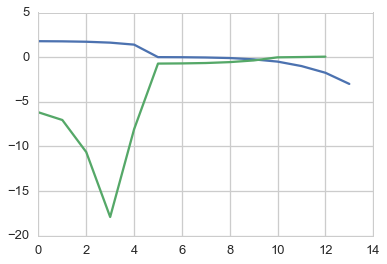

In [82]:
print(depths[:int(ds.nLayers.values[4000]) - int(ds.nSoil.values[4000]), 4000])
plt.plot(depths[:, 4000])
plt.plot(tmp[:, 4000])

In [14]:
print(ds)

<xarray.Dataset>
Dimensions:                (ifcSoilAndTime: 112574, ifcTotoAndTime: 112574, midTotoAndTime: 112574, time: 8041)
Coordinates:
  * time                   (time) datetime64[ns] 2008-10-01 ...
    hru                    int32 1
Dimensions without coordinates: ifcSoilAndTime, ifcTotoAndTime, midTotoAndTime
Data variables:
    pptrate                (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    airtemp                (time) float64 275.8 275.7 275.7 275.4 275.5 ...
    nSnow                  (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
    nSoil                  (time) int32 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 ...
    nLayers                (time) int32 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 ...
    midTotoStartIndex      (time) int32 1 9 17 25 33 41 49 57 65 73 81 89 97 ...
    ifcSoilStartIndex      (time) int32 1 10 19 28 37 46 55 64 73 82 91 100 ...
    ifcTotoStartIndex      (time) int32 1 10 19 28 37 46 55 64 73 82 91 100 ...
    scalarSnowDepth        (t